In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 2.x
import numpy
import os
import sys
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
batch_size = 64
root = '/content/drive/My Drive/Experimental Projects/Bird Genus'
data_path = os.path.join(root, 'data')
npz_path = os.path.join(root, 'audio_npz')

In [0]:
sys.path.append(root)
from models import ConvolutionalRNN, SimpleRNN

In [0]:
def get_data():
    x_train = numpy.empty((0, 862, 128))
    y_train = numpy.empty((0, 182))
    for npz_file in os.listdir(npz_path):
        npz = numpy.load(os.path.join(npz_path, npz_file))
        x_train = numpy.concatenate((x_train, npz['train']), axis=0)
        y_train = numpy.concatenate((y_train, npz['test']), axis=0)
    return x_train, y_train

In [0]:
x_train, y_train = get_data()

In [0]:
def plot_accuracy_summary(history):
    plt.title('Loss')
    plt.plot(history.history['categorical_accuracy'], label='train')
    plt.plot(history.history['val_categorical_accuracy'], label='test')
    plt.legend()
    plt.show()

In [9]:
crnn_model = ConvolutionalRNN().get_model()
crnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 858, 56)           35896     
_________________________________________________________________
batch_normalization (BatchNo (None, 858, 56)           224       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 858, 56)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 429, 56)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 425, 56)           15736     
_________________________________________________________________
batch_normalization_1 (Batch (None, 425, 56)           224       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 425, 56)          

In [10]:
rnn_model = SimpleRNN().get_model()
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 182)              

In [0]:
reducelr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy',
                                                         factor=0.2,
                                                         patience=5,
                                                         min_delta=0.01,
                                                         verbose=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(os.path.join(root, 'weights', 'best_weights.h5'),
                                                         monitor='val_categorical_accuracy',
                                                         verbose=1,
                                                         save_best_only=True, mode='max')

callbacks_list = [checkpoint_callback, reducelr_callback]

In [12]:
crnn_model.compile(loss='categorical_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=[tf.keras.metrics.CategoricalAccuracy()])
history = crnn_model.fit(x_train, y_train, epochs=50, verbose=2, validation_split=0.2, batch_size=64, callbacks=callbacks_list)

Train on 7176 samples, validate on 1794 samples
Epoch 1/50

Epoch 00001: val_categorical_accuracy improved from -inf to 0.04961, saving model to /content/drive/My Drive/Experimental Projects/Bird Genus/weights/best_weights.h5
7176/7176 - 15s - loss: 5.4259 - categorical_accuracy: 0.0500 - val_loss: 5.4481 - val_categorical_accuracy: 0.0496
Epoch 2/50

Epoch 00002: val_categorical_accuracy did not improve from 0.04961
7176/7176 - 4s - loss: 4.9918 - categorical_accuracy: 0.0783 - val_loss: 5.3284 - val_categorical_accuracy: 0.0474
Epoch 3/50

Epoch 00003: val_categorical_accuracy did not improve from 0.04961
7176/7176 - 4s - loss: 4.6140 - categorical_accuracy: 0.1067 - val_loss: 5.4972 - val_categorical_accuracy: 0.0340
Epoch 4/50

Epoch 00004: val_categorical_accuracy improved from 0.04961 to 0.12319, saving model to /content/drive/My Drive/Experimental Projects/Bird Genus/weights/best_weights.h5
7176/7176 - 4s - loss: 4.3404 - categorical_accuracy: 0.1336 - val_loss: 4.5100 - val_cat

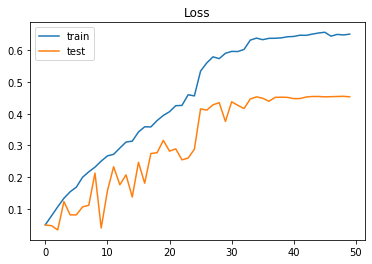

In [15]:
plot_accuracy_summary(history)